In [1]:
import numpy as np
import matplotlib.pyplot as plt

This tutorial shows how to work with multiple Visium datasets and perform integration of scRNA-seq dataset with Scanpy. It follows the previous tutorial on analysis and visualization of spatial transcriptomics data.

We will use Scanorama paper - code to perform integration and label transfer. It has a convenient interface with scanpy and anndata.

Based on: https://scanpy-tutorials.readthedocs.io/en/latest/spatial/integration-scanorama.html

In [2]:
!pip install git+https://github.com/theislab/scanpy.git
!pip install git+https://github.com/theislab/anndata.git
!pip install scanorama

  Cloning https://github.com/theislab/scanpy.git to /private/var/folders/_v/83fnj05d4_dbryrd3hxr2f4r0000gn/T/pip-req-build-24wn7_pa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for scanpy: filename=scanpy-1.9.0.dev33+gcab9f781-py3-none-any.whl size=11378895 sha256=db1e8c9448e6d84e4eb780dffe8f0e0996adf01b1ab0264570e3d3b0397199d8
  Stored in directory: /private/var/folders/_v/83fnj05d4_dbryrd3hxr2f4r0000gn/T/pip-ephem-wheel-cache-4myalt17/wheels/8e/dc/cc/c16967eb15acc1665f08d8eedb497346edc144e1b152fb6b1b
Successfully built scanpy
You should consider upgrading via the '/Users/nemo/Documents/projects/sandbox/single-cell/venvsingle/bin/python -m pip install --upgrade pip' command.
  Cloning https://github.com/theislab/anndata.git to /private/var/folders/_v/83fnj05d4_dbryrd3hxr2f4r0000gn/T/pip-req-build-bu2sm20v
  Installing build dependencies ... done
 

In [3]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanorama

In [5]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

Fail to get yarn configuration. dyld: Library not loaded: /usr/local/opt/icu4c/lib/libicui18n.64.dylib
  Referenced from: /usr/local/bin/node
  Reason: image not found



The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.9.dev2+g286bc7f
scanpy      1.9.0.dev33+gcab9f781
sinfo       0.3.4
-----
PIL                         8.4.0
annoy                       NA
anyio                       NA
appnope                     0.1.2
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
certifi                     2021.10.08
cffi                        1.15.0
charset_normalizer          2.0.7
cycler          

## Reading the data

We will use two Visium spatial transcriptomics dataset of the mouse brain (Sagittal), which are publicly available from the 10x genomics website.

The function datasets.visium_sge() downloads the dataset from 10x genomics and returns an AnnData object that contains counts, images and spatial coordinates. We will calculate standards QC metrics with pp.calculate_qc_metrics and visualize them.

When using your own Visium data, use Scanpy’s read_visium() function to import it.


In [6]:
adata_spatial_anterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Anterior"
)
adata_spatial_posterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Posterior"
)

100%|████████████████████████████████| 8.81M/8.81M [00:02<00:00, 3.39MB/s]
100%|████████████████████████████████| 19.6M/19.6M [00:04<00:00, 4.51MB/s]

reading /Users/nemo/Documents/projects/sandbox/single-cell/data/V1_Mouse_Brain_Sagittal_Anterior/filtered_feature_bc_matrix.h5



Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
100%|████████████████████████████████| 9.26M/9.26M [00:02<00:00, 3.58MB/s]
100%|████████████████████████████████| 20.1M/20.1M [00:04<00:00, 4.49MB/s]

reading /Users/nemo/Documents/projects/sandbox/single-cell/data/V1_Mouse_Brain_Sagittal_Posterior/filtered_feature_bc_matrix.h5



Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
adata_spatial_anterior.var_names_make_unique()
adata_spatial_posterior.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata_spatial_anterior, inplace=True)
sc.pp.calculate_qc_metrics(adata_spatial_posterior, inplace=True)

/Users/nemo/Documents/projects/sandbox/single-cell/venvsingle/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11103. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/Users/nemo/Documents/projects/sandbox/single-cell/venvsingle/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


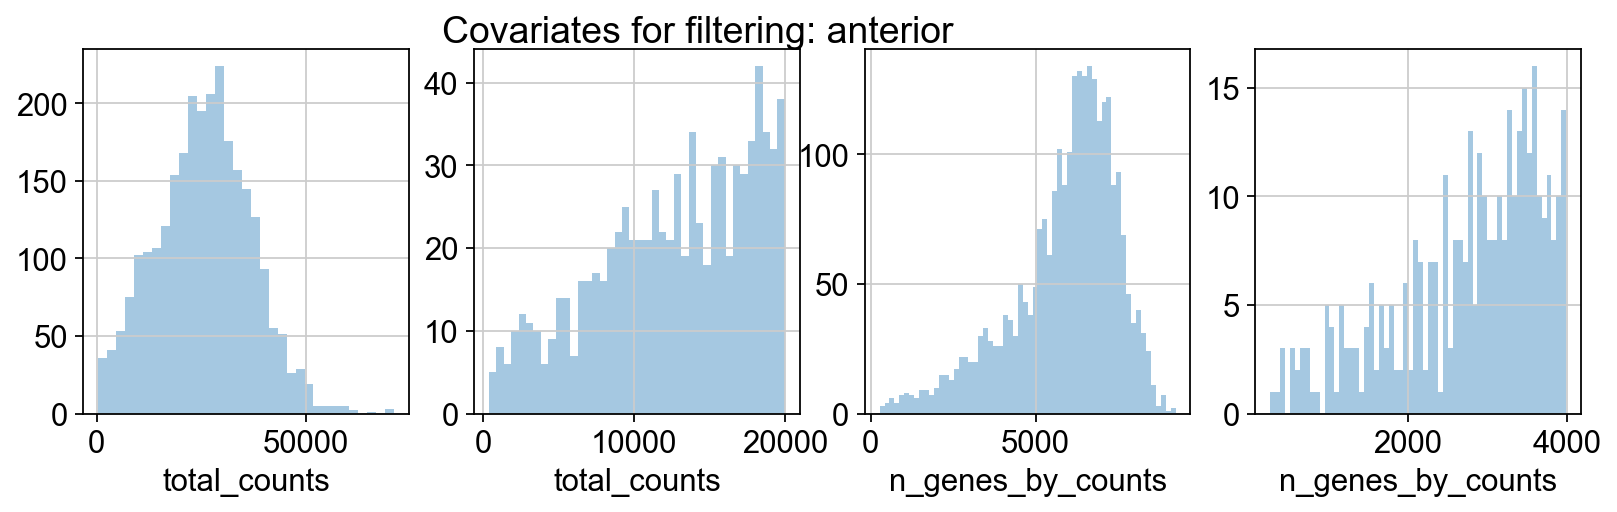

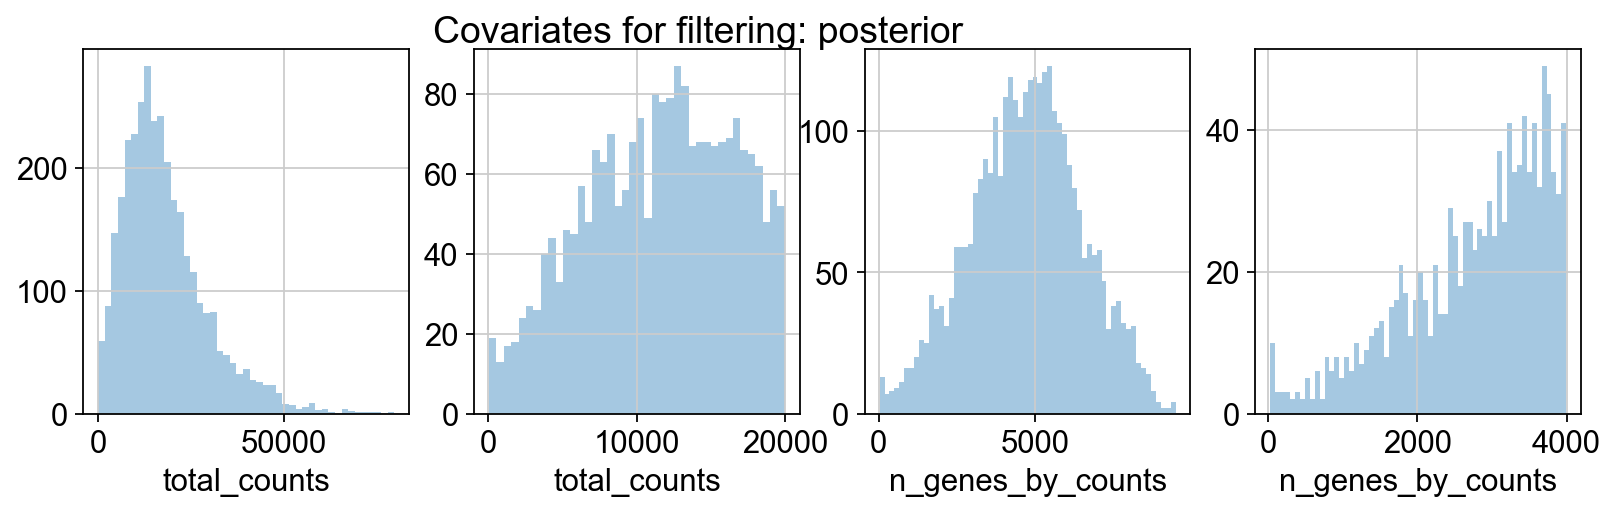

In [8]:
for name, adata in [
    ("anterior", adata_spatial_anterior),
    ("posterior", adata_spatial_posterior),
]:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(f"Covariates for filtering: {name}")

    sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
    sns.distplot(
        adata.obs["total_counts"][adata.obs["total_counts"] < 20000],
        kde=False,
        bins=40,
        ax=axs[1],
    )
    sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.distplot(
        adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
        kde=False,
        bins=60,
        ax=axs[3],
    )

In [9]:
for adata in [
    adata_spatial_anterior,
    adata_spatial_posterior,
]:
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [10]:
adatas = [adata_spatial_anterior, adata_spatial_posterior]
adatas_cor = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 32285 genes among all datasets
[[0.         0.47958271]
 [0.         0.        ]]
Processing datasets (0, 1)


In [11]:
adata_spatial = adatas_cor[0].concatenate(
    adatas_cor[1],
    batch_key="library_id",
    uns_merge="unique",
    batch_categories=[
        k
        for d in [
            adatas_cor[0].uns["spatial"],
            adatas_cor[1].uns["spatial"],
        ]
        for k, v in d.items()
    ],
)

In [14]:
sc.pp.neighbors(adata_spatial, use_rep="X_scanorama")
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial, key_added="clusters")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 22 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/nemo/Documents/projects/sandbox/single-cell/venvsingle/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/Users/nemo/Documents/projects/sandbox/single-cell/venvsingle/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


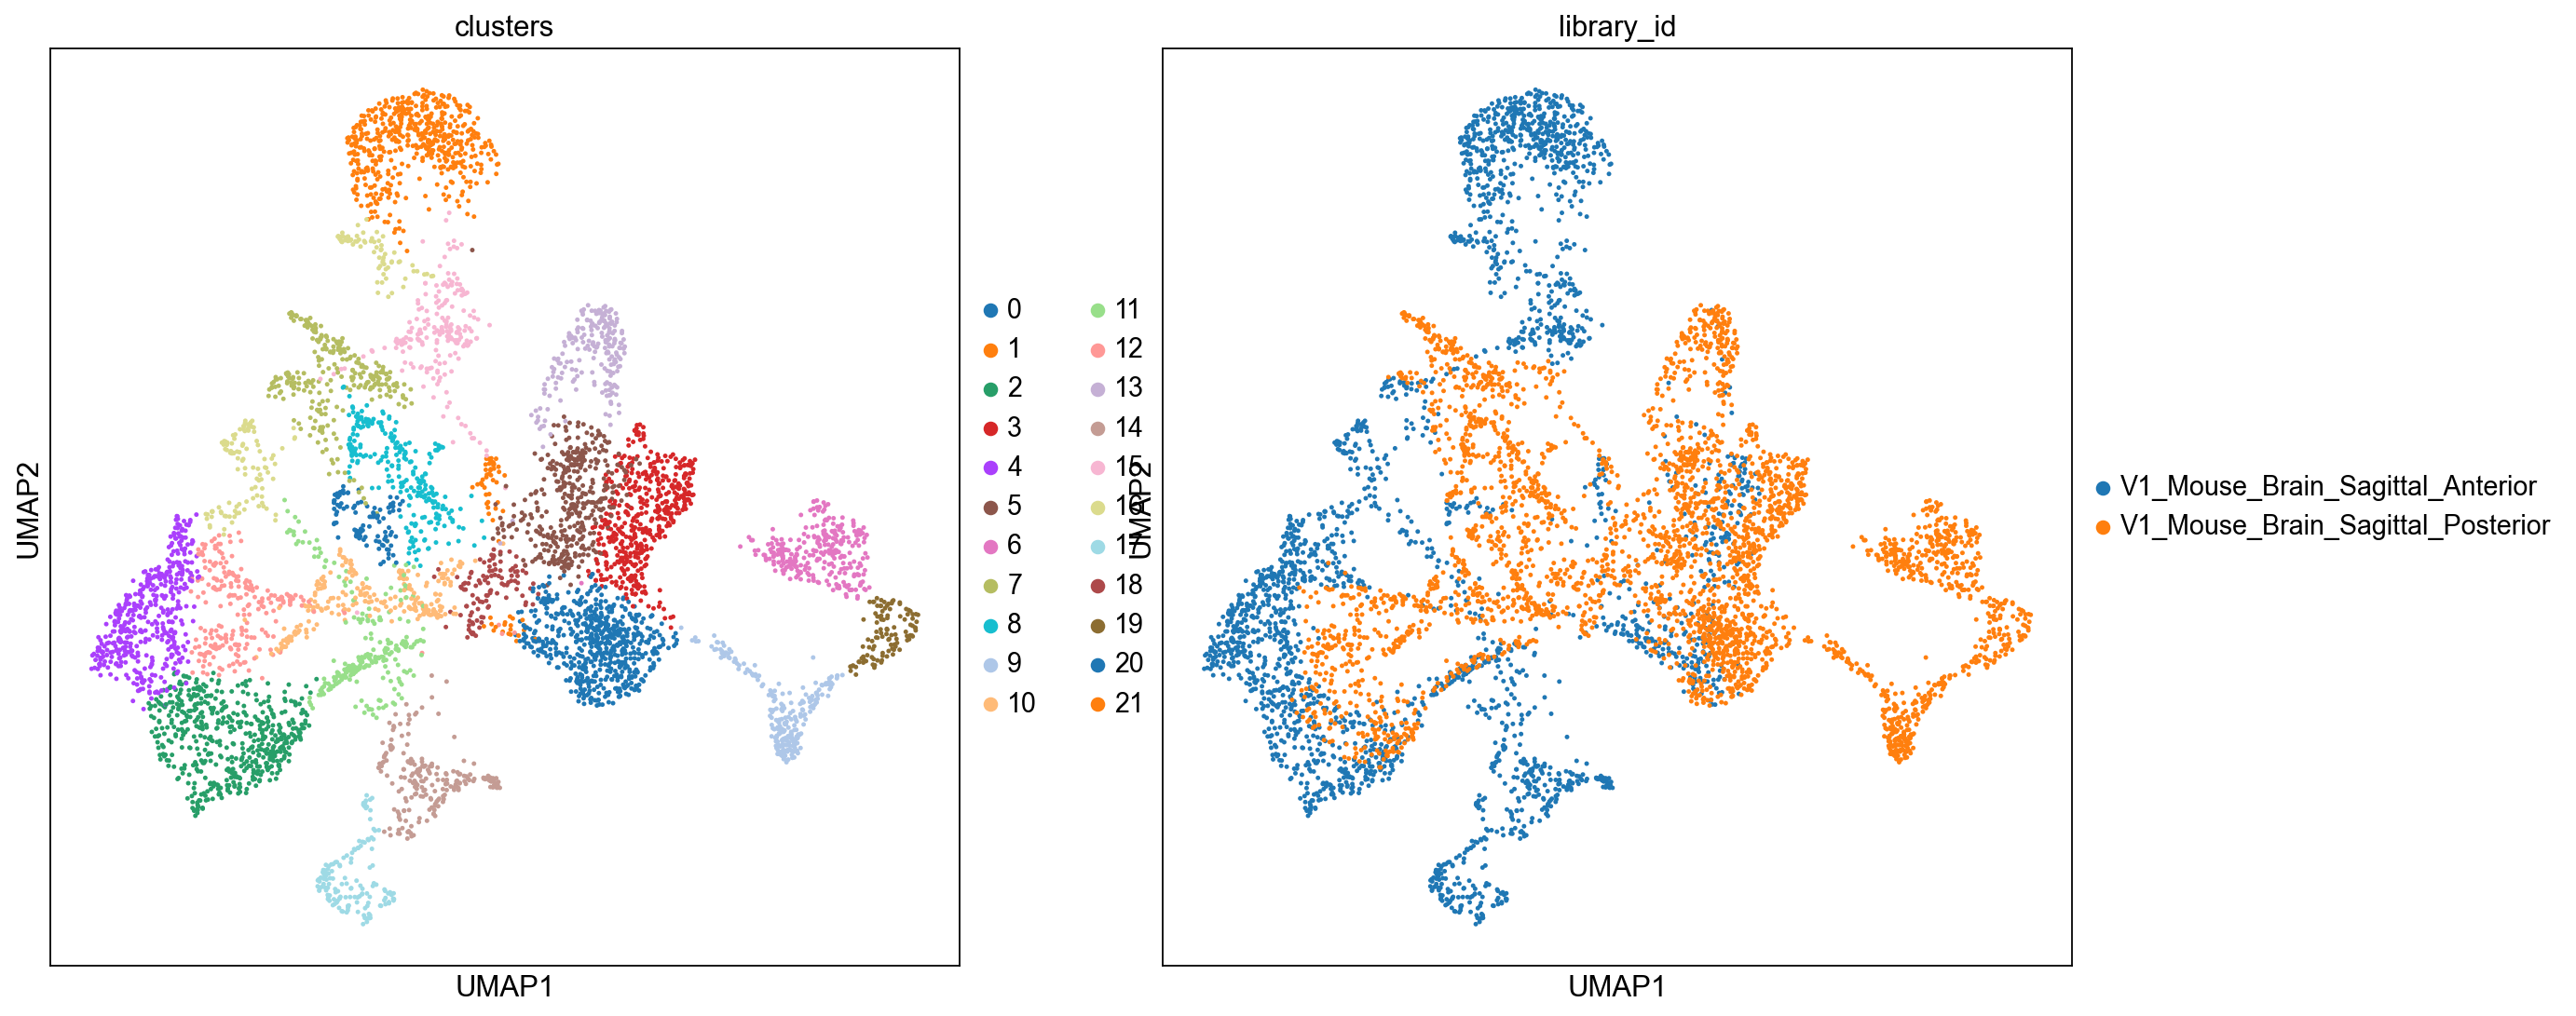

In [15]:
sc.pl.umap(
    adata_spatial, color=["clusters", "library_id"], palette=sc.pl.palettes.default_20
)

We can also visualize the clustering result in spatial coordinates. For that, we first need to save the cluster colors in a dictionary. We can then plot the Visium tissue fo the Anterior and Posterior Sagittal view, alongside each other.



In [16]:
clusters_colors = dict(
    zip([str(i) for i in range(18)], adata_spatial.uns["clusters_colors"])
)

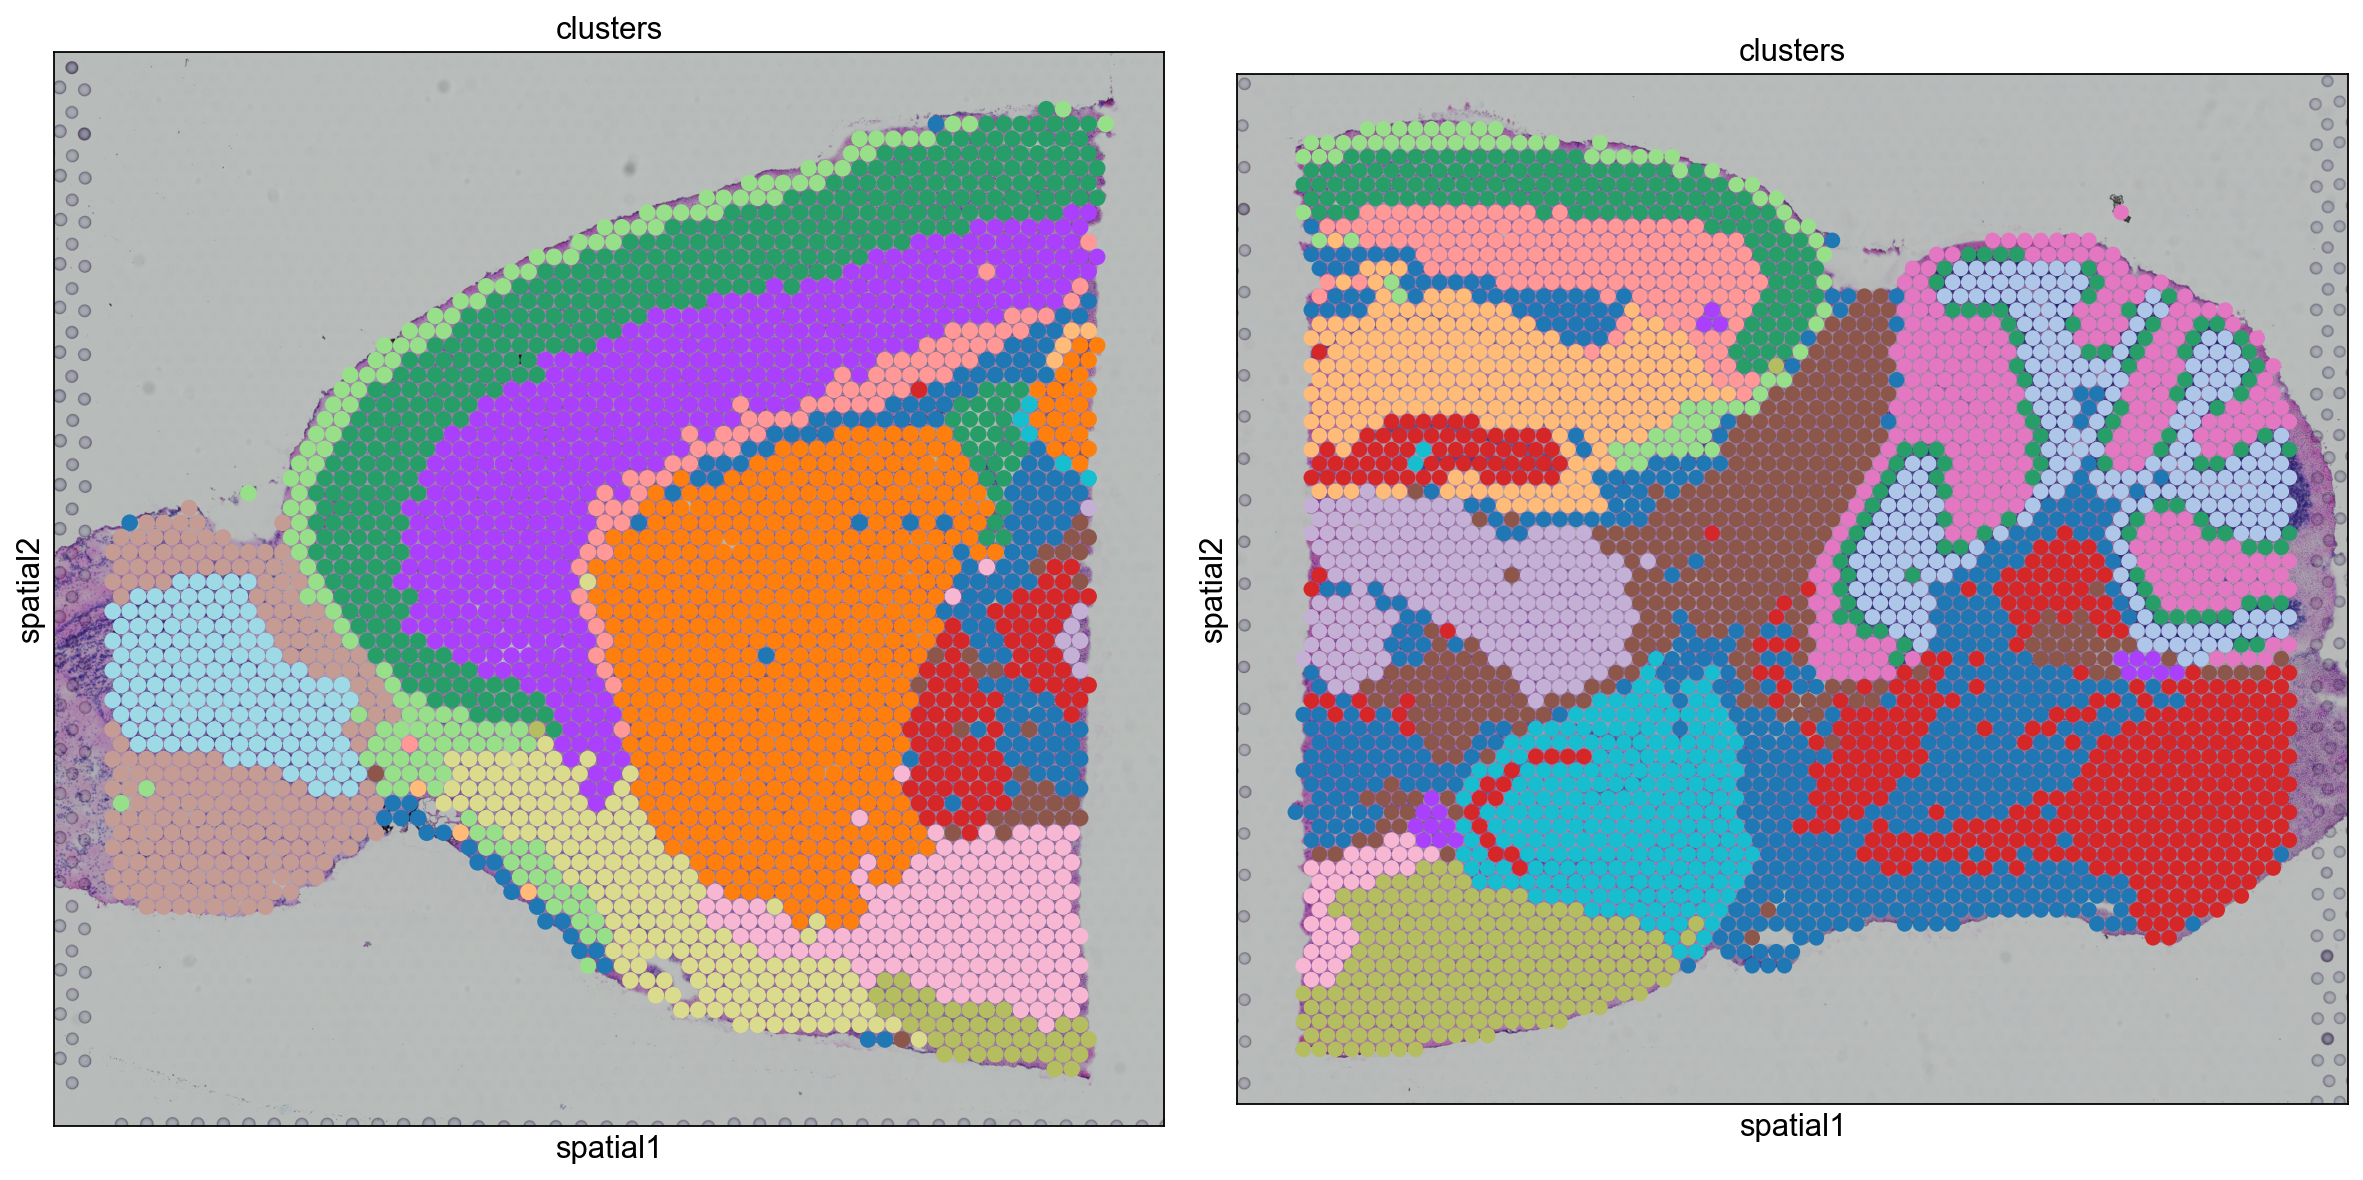

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for i, library in enumerate(
    ["V1_Mouse_Brain_Sagittal_Anterior", "V1_Mouse_Brain_Sagittal_Posterior"]
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="clusters",
        size=1.5,
        
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs.clusters.unique().tolist()
        ],
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()